# Final Project Degree

## Prediction of cardiovascular and bleeding events in patients with double antiaggregation with machine learning models.

##### Pablo Pérez Sánchez
---

# 1. Preprocess Database

---
**Import libarys**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


---
**Import data**

In [2]:
df = pd.read_excel('../../data/PACS_DAPT_completo.xlsx')

In [3]:
# df.head()

---
**Preprocess Database**

1. We pass on the categorical variables to a binary classification.

2. Create a new variable "IMC".

3. Create two new variables from LVEFgroups.

4. Set the bleeding and reinflation times well in the "Vigo_Arritxaca" register.

5. Create new variables that classified infarction/bleeding at 6 months, 12 months and 24 months.


---
**1. We pass on the categorical variables to a binary classification.**

"Female" = 1 / "Male" = 2  
"No" = 0 / "Yes" = 1

In [4]:
# Variables that need to be changed

replace_vars = ['Sex','Diabetes', 'Hypertension', 'Dyslipemia', 'PeripheralArteryDisease', 'PriorMyocardialInfarction',
                'PriorPCI', 'PriorCABG', 'PriorStroke', 'Cancer', 'Prior_Bleeding', 'STEMI', 'UnstableAngina',
                'Killip2orMore', 'Femoral_Access', 'Multivessel', 'DrugElutingStent', 'Revascularization_Complete',
                'ReAMI_inhospital', 'Bleeding_inhospital', 'Transfusion_IH', 'Clopidogrel', 'Ticagrelor', 'Prasugrel',
                'OralAnticoagulation', 'Betablockers', 'ACEI_ARB', 'Statin', 'Death', 'ReInfarction','Bleeding', 'Transfusion']

# create a dictionary with the changes
dic = {'Female': 1, 'Male': 2, 'Yes': 1, 'No': 0, np.nan:np.nan,'NaN':np.nan, 1:1, 0:0}

In [5]:
# Do the change
for i in replace_vars:
    #print(i)
    df[i] = df[i].apply(lambda x:dic[x])

---

**2. Create a new variable "IMC"**

![image.png](attachment:image.png "IMC = Peso(kg)/Talla(m)^2")

- Bleemacs: No "talla" no "peso".
- Renami: Talla = IMC.
- Vigo_Arritxaca: Peso y Talla, calculate IMC

Before making changes, have several patients with inconsistent data in the database.
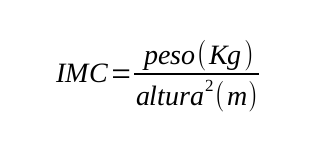

In [6]:
df.loc[(df['Registro']=='Vigo_Arritxaca') & (df['Talla']<100), ['Id','Talla']].shape

(25, 2)

We have 25 patients where "Talla" is less than 100 cm:
  - 20 patients with Talla: -1
  - 3 patients with Talla: 1
  - 1 patients with Talla: 0
  - 1 patients with Talla: 19 
  
Replace them with the average?

In [7]:
# calculate IMC:
# - BLEEMACS haven't talla and peso

# - RENAMI the talla is equal to IMC
df['IMC'] = df.loc[df['Registro']=='RENAMI', 'Talla']

# - Vigo_Arritxaca calculate it without putting in values less than 100cm
df['IMC'] = df.loc[(df['Registro']=='Vigo_Arritxaca') & (df['Talla']>100), 'Peso'] / ((df.loc[(df['Registro']=='Vigo_Arritxaca') & (df['Talla']>100), 'Talla']/100) * (df.loc[(df['Registro']=='Vigo_Arritxaca') & (df['Talla']>100), 'Talla']/100))

In [8]:
# The 24 patients with "Talla" = (-1, 0, 1), are replaced by the average.
IMC_media_Vigo = df.loc[(df['Registro']=='Vigo_Arritxaca') & (df['Talla']>100), 'IMC'].mean()

df.loc[(df['Registro']=='Vigo_Arritxaca') & (df['Talla']==-1) ,'IMC'] = IMC_media_Vigo
df.loc[(df['Registro']=='Vigo_Arritxaca') & (df['Talla']==0) ,'IMC'] = IMC_media_Vigo
df.loc[(df['Registro']=='Vigo_Arritxaca') & (df['Talla']==1) ,'IMC'] = IMC_media_Vigo
df.loc[df['Id']==24445,'IMC'] = IMC_media_Vigo

# # El paciente con Id: 24445 tiene Talla = 19, la sustituimos por Talla = 190
# df.loc[df['Id']==24445,'Talla'] = 190

---

**3. Create two new variables from LVEFgroups.**

From "LVEFgroups" we get the variables: "LVEFless40", "LVEFless50" and "LVEFafter50".

In [9]:
# Create two new columns equivalent to LVEFless40
df['LVEFless50'] = 0
df['LVEFafter50'] = 0

df.loc[~(df['LVEFgroups']=='LVEF 40-49'),'LVEFless50'] = 1

# df.loc[~(df['LVEFgroups']=='LVEF > 50'),'LVEFless50'] = 1 # Si queremos hacerlo de manera escalonada
df.loc[~(df['LVEFgroups']=='LVEF > 50'),'LVEFafter50'] = 1

---

**4. Set the bleeding and reinflation times well in the "Vigo_Arritxaca" register.**

I'll use "event" to refer to reinfarction or bleeding  
**LengthDapt_months "**: medication time, time from discharge to the next event.  
**Months_reAMI "**: reinfarction time, time from the first heart attack to the second.  
**Months_Bleeding "**: time of bleeding, time from first infarct to bleeding.  

After any event the medication is changed.

Example:  
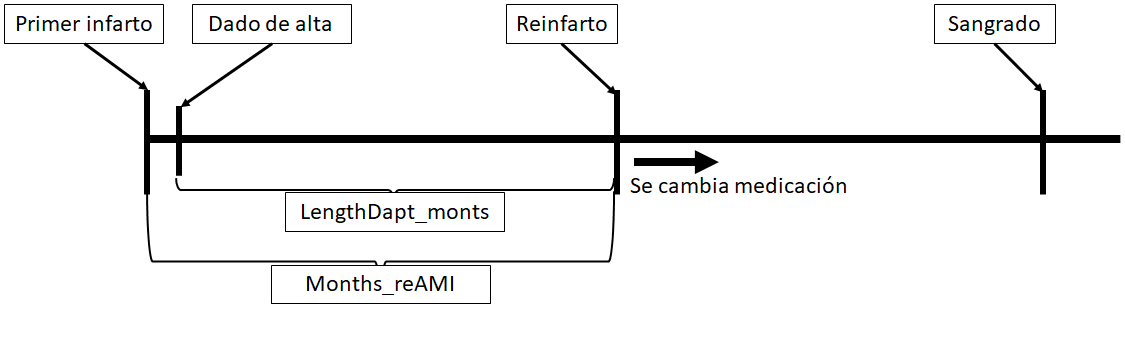

After reinfarction, the medication is changed, so the bleeding is no longer valid.  
We must set the time of measurement equal to the time of reinfarction.

**create two new variables: "ReInfarctionDapt", "ReInfarctionAfterDapt", "BleedingDapt" and "BleedinfAfterDapt" in order to be able to perform a study during medication and after medication**

It will be necessary to change the functions created below and make new ones.

In [10]:
# Create a function to establish the medication times in Vigo_Arritxaca

def tiempoDapt(x):
    if x['Registro']=='Vigo_Arritxaca':
        x['LengthDapt_months'] = 0.5 + x['LengthDapt_months']
    return x['LengthDapt_months']

df['LengthDapt_months'] = df.apply(tiempoDapt, axis = 1)

In [11]:
# Create different functions and then clean up the basis for more than one event.

# With this function we change the status of whether or not the patient has bled
def sangradoFalso(x):
    if x['Bleeding']==1 and x['ReInfarction'] == 1 and x['Months_reAMI'] < x['Months_Bleeding']:
        x['Bleeding'] = 0
    return x['Bleeding']

# With this function we change the state of whether or not the patient has suffered another heart attack
def reamiFalso(x):
    if x['Bleeding']==1 and x['ReInfarction'] == 1 and x['Months_Bleeding'] < x['Months_reAMI']:
        x['ReInfarction'] = 0
    return x['ReInfarction']

In [12]:
%%time
# Run the entire functions in our database

df['Bleeding'] = df.apply(sangradoFalso, axis = 1)
df['ReInfarction']= df.apply(reamiFalso, axis = 1)

Wall time: 2.89 s


In [13]:
# Create different functions for the creation of new variables of the events during and after medication

# With this function we see if the patient has bled during the medication
def sangradoDapt(x):
    if x['Bleeding']==1 and x['LengthDapt_months'] >= x['Months_Bleeding']:
        x['BleedingDapt'] = 1
    return x['BleedingDapt']
# With this function we see if the patient has bled after medication
def sangradoAfterDapt(x):
    if x['Bleeding']==1 and x['LengthDapt_months'] < x['Months_Bleeding']:
        x['BleedinfAfterDapt'] = 1
    return x['BleedinfAfterDapt']


# With this function we see if the patient has suffered another heart attack during medication
def reamiDapt(x):
    if x['ReInfarction'] == 1 and x['LengthDapt_months'] >= x['Months_reAMI']:
        x['ReInfarctionDapt'] = 1
    return x['ReInfarctionDapt']
# With this function we see if the patient has suffered another heart attack after medication
def reamiAfterDapt(x):
    if x['ReInfarction'] == 1 and x['LengthDapt_months'] < x['Months_reAMI']:
        x['ReInfarctionAfterDapt'] = 1
    return x['ReInfarctionAfterDapt']

In [14]:
%%time
df['BleedingDapt'] = 0
df['BleedinfAfterDapt'] = 0
df['ReInfarctionDapt'] = 0
df['ReInfarctionAfterDapt'] = 0

# We run the entire functions in our database
df['BleedingDapt'] = df.apply(sangradoDapt, axis = 1)
df['BleedinfAfterDapt'] = df.apply(sangradoAfterDapt, axis = 1)
df['ReInfarctionDapt']= df.apply(reamiDapt, axis = 1)
df['ReInfarctionAfterDapt']= df.apply(reamiAfterDapt, axis = 1)

Wall time: 3.95 s


---

**5. Create new variables that classified infarction/bleeding at 6 months, 12 months and 24 months.**

In [15]:
# WHILE THE MEDICATION
# Create a new variable, to study if he had a heart attack or bleeding before the age of 6 months.
df['reAMIless6Dapt'] = 0
df.loc[(df['Months_reAMI'] <= 6) & (df['ReInfarctionDapt']==1), 'reAMIless6Dapt'] = 1

df['bleedingless6Dapt'] = 0
df.loc[(df['Months_Bleeding'] <= 6) & (df['BleedingDapt']==1), 'bleedingless6Dapt'] = 1

# Create a new variable, to study if he had a heart attack or bleeding before the age of 12 months
df['reAMIless12Dapt'] = 0
df.loc[(df['Months_reAMI'] <= 12) & (df['ReInfarctionDapt']==1), 'reAMIless12Dapt'] = 1

df['bleedingless12Dapt'] = 0
df.loc[(df['Months_Bleeding'] <= 12) & (df['BleedingDapt']==1), 'bleedingless12Dapt'] = 1

# Create a new variable, to study if he had a heart attack or bleeding before the age of 24 months
df['reAMIless24Dapt'] = 0
df.loc[(df['Months_reAMI'] <= 24) & (df['ReInfarctionDapt']==1), 'reAMIless24Dapt'] = 1

df['bleedingless24Dapt'] = 0
df.loc[(df['Months_Bleeding'] <= 24) & (df['BleedingDapt']==1), 'bleedingless24Dapt'] = 1

Since the study will be performed during medication, it is not necessary to run the following block of commands

In [16]:
# # Creamos una nueva variable, para estududiar si tuvo infarto o sangrado antes de los 6 meses.
# df['reAMIless6'] = 0
# df.loc[(df['Months_reAMI'] <= 6) & (df['ReInfarction']==1), 'reAMIless6'] = 1

# df['bleedingless6'] = 0
# df.loc[(df['Months_Bleeding'] <= 6) & (df['Bleeding']==1), 'bleedingless6'] = 1

# # Creamos una nueva variable, para estududiar si tuvo infarto o sangrado antes de los 12 meses.
# df['reAMIless12'] = 0
# df.loc[(df['Months_reAMI'] <= 12) & (df['ReInfarction']==1), 'reAMIless12'] = 1

# df['bleedingless12'] = 0
# df.loc[(df['Months_Bleeding'] <= 12) & (df['Bleeding']==1), 'bleedingless12'] = 1

# # Creamos una nueva variable, para estududiar si tuvo infarto o sangrado antes de los 24 meses.
# df['reAMIless24'] = 0
# df.loc[(df['Months_reAMI'] <= 24) & (df['ReInfarction']==1), 'reAMIless24'] = 1

# df['bleedingless24'] = 0
# df.loc[(df['Months_Bleeding'] <= 24) & (df['Bleeding']==1), 'bleedingless24'] = 1

---
**Export Preprocess Database**

In [17]:
# df.to_excel('../../data/PACS_DAPT_preprocess.xlsx')
df.to_csv('../../data/PACS_DAPT_preprocess.csv')